In [2]:
from gdeep.topactivation import TopactivationFC as TFC
from gdeep.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter

from gdeep.models import FFNet
from torch import nn
import torch
from gdeep.data import TorchDataLoader
from tqdm import tqdm 

!pip3 install xitorch
from gdeep.models import ModelExtractor
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
import matplotlib.pyplot as plt 

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU!")
else:
    DEVICE = torch.device("cpu")

    
# To REMOOOOOOOOOOOOOOOOOOOOOOOOVE 
#DEVICE = torch.device("cpu")

def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')
    
    
writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

Using GPU!
Using GPU!
Using GPU!
No TPUs...
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Using GPU!


In [3]:
# Loading the data 
activ = torch.load('/home/meller/Documents/giotto-deep/examples/saves/activ_v5')
model = torch.load('/home/meller/Documents/giotto-deep/examples/saves/model_v5')
activG =torch.load('/home/meller/Documents/giotto-deep/examples/saves/activG_v5')

writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)


#cpu = torch.ones(1).device


arch = [28*28,100,50,50,50, 10]
optimizer = torch.optim.SGD
loss_fn = nn.CrossEntropyLoss()
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())


predLabel = torch.zeros(activ.shape[0],activ.shape[1])
for alter in range(activ.shape[0]):
    predLabel[alter] = activ[alter,:,-10:].argmax(dim=1)
    
    
label = torch.zeros(activ[0].shape[0])
k_batch = 0 
for data, target in tqdm(dl_tr):
    label[k_batch*32:(k_batch+1)*32]=target
    k_batch+=1
    if k_batch*32>=activ[0].shape[0]:
        break 

 43%|████████████████▌                      | 799/1875 [00:02<00:02, 397.78it/s]


In [4]:
import os 
os.system('ls')

basic_tutorial_gridsearch_benchmarking.ipynb
basic_tutorial_image.ipynb
basic_tutorial_QandA.ipynb
basic_tutorial_regression.ipynb
basic_tutorial_tabular.ipynb
basic_tutorial_textClass.ipynb
basic_tutorial_translation.ipynb
compactification.ipynb
data
decision_boundary_tori.ipynb
Ensemble_learning.ipynb
Intersection_Homology.ipynb
kernelAnalysis.ipynb
lapInputLayer
lapInputLayerBin
lapInputLayer.zip
LaplacianSpectralAnalysis.ipynb
networkEvolution.ipynb
optimising_topology.ipynb
orbit_5k_train.ipynb
reflexiveNetworks.ipynb
rotation_network.ipynb
runs
saves
spectral_analysis_cnn.ipynb
TopactivationFC_tutorial.ipynb


0

In [33]:

import pandas as pd 
import plotly.express as px
import plotly.graph_objects as go
import numpy as np 
import os 


def mode_transform_save(weights,name,nodeColor='blue',sigmaThreshold=3):
    S = []
    V = []
    U = []
    K = []
    for layer in weights:
        u,s,v= torch.svd(layer)
        U.append(u.to('cpu'))
        S.append(s.to('cpu'))
        V.append(v.to('cpu'))

    adjacency = [V[i+1].T@U[i] for i in range(len(V)-1)]



    def y_scale(x):
        return x 
        return (x-0.4)**0.2

    df = pd.DataFrame({})
    fig = px.scatter(df)


    #Edges  
    for k in range(len(adjacency)):
        E2=torch.abs(adjacency[k])
        for i in range(E2.shape[0]):
            for j in range(E2.shape[1]):
                Emin = sigmaThreshold*1/np.sqrt(arch[k+1]) # 3 sigma away from the random uniform baseline 
                if E2[i,j]>Emin:
                    edge = pd.DataFrame({"x" : [k,k+1],"y": [y_scale(S[k][j]).item(),y_scale(S[k+1][i]).item()]})
                    #figEdge = go.scatter.Line(x=[k,k+1],y=[y_scale(S[k][j]),y_scale(S[k+1][i])],fillcolor='grey')

                    #fig.add_trace(figEdge)
                    coeff = 1-(E2[i,j]-Emin)/(E2.max()-Emin) # A mieux faire 
                    color = coeff.item()*np.array([120,120,120])+np.array([105,105,105])
                    r,g,b=int(color[0]),int(color[1]),int(color[2])
                    color = "rgb"+str((r,g,b))
                    fig.add_scatter(x=edge["x"],y=edge["y"],marker={"color":color,"opacity":1},hovertext=str(adjacency[k][i,j])
                                   ,hoveron="fills",hoverinfo="text",text=str(adjacency[k][i,j]),showlegend=False ) 

                    middle_node_trace = go.Scatter(
                        x=[np.array(edge["x"]).mean()],
                        y=[np.array(edge["y"]).mean()],
                        text=[str(adjacency[k][i,j])],
                        mode='markers',
                        hoverinfo='text',
                        showlegend=False,
                        marker=go.scatter.Marker(
                            opacity=0,
                            color='lightgrey'
                        )
                    )

                    fig.add_trace(middle_node_trace)




    base=0
    for i in range (len(S)):
        layer_i = pd.DataFrame({'x' : len(S[i])*[i], 'y': y_scale(S[i])})
        df = pd.concat([df,layer_i])
        base+=len(S[i])


    #fig.add_scatter(x=df["x"], y=df["y"])           
    node_trace = go.Scatter(
        x=df["x"],
        y=df["y"],
        mode='markers',
        showlegend=False,
        marker=go.scatter.Marker(
            opacity=1,
            color = nodeColor
        ))

    fig.add_trace(node_trace)

    #fig.show()
    fig.write_image("record/"+name+'.png')
    return U,S,V


In [23]:
res = mode_transform_save([torch.rand(4,5),torch.rand(8,4),torch.rand(40,8),torch.rand(10,40)],'test')

In [34]:
#from gdeep.data import DataLoaderFromArray -> Useless 

def train_record_new_model(model,X,y,folder,epochs=5):
        
    Ntest = 32*30
    perm = torch.randperm(len(X))
    batch_size=32


    X_train = X[perm[Ntest:]]
    y_train = y[perm[Ntest:]].type(torch.LongTensor)
    X_val = X[perm[:Ntest]]
    y_val = y[perm[:Ntest]].type(torch.LongTensor)


    #model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False )).to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
    #optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()

    
    if not os.path.exists('record/'+folder):
        os.mkdir('record/'+folder)
    
    
    for epoch in range(epochs):
        correct_pred = 0
        total_pred = 0
        model.train()
        for batch_idx in tqdm(range(len(X_train)//batch_size)):
            data = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size].reshape(batch_size,1,28,28).to(DEVICE)
            target = y_train[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)

            weights = [A.detach() for A in list(model.parameters())]
            name = folder+'/'+str(epoch)+'_'+str(batch_idx)
            res = mode_transform_save(weights,name)
            
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]
        print(15*'-'+' ', 'Epoch : ', epoch, ' ' + 15*'-')
        print('Train Accuracy : ',correct_pred/total_pred*100, ' %')
        model.eval()
        correct_pred = 0
        total_pred = 0
        for batch_idx in range(len(X_val)//batch_size):
            data = X_val[batch_idx*batch_size:(batch_idx+1)*batch_size].reshape(batch_size,1,28,28).to(DEVICE)
            target = y_val[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)

            output = model(data)


            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]

        print('Test Accuracy : ',correct_pred/total_pred*100, ' %') 
    return model 

In [31]:
#Vanilla test 
m= train_record_new_model(arch,activ[0][:,:28*28],label,folder='m0',epochs=3)

100%|█████████████████████████████████████████| 770/770 [05:19<00:00,  2.41it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  62.46753246753247  %
Test Accuracy :  88.64583333333333  %


100%|█████████████████████████████████████████| 770/770 [06:28<00:00,  1.98it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  92.39853896103895  %
Test Accuracy :  93.75  %


100%|█████████████████████████████████████████| 770/770 [06:36<00:00,  1.94it/s]

---------------  Epoch :  2  ---------------
Train Accuracy :  95.2719155844156  %
Test Accuracy :  96.14583333333333  %


In [36]:
mfgsm= train_record_new_model(m,activ[1][:,:28*28],label,folder='m0-fgsm',epochs=3)

100%|█████████████████████████████████████████| 770/770 [06:57<00:00,  1.84it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  92.78003246753246  %
Test Accuracy :  98.33333333333333  %


100%|█████████████████████████████████████████| 770/770 [07:03<00:00,  1.82it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  99.09902597402598  %
Test Accuracy :  98.64583333333333  %


100%|█████████████████████████████████████████| 770/770 [06:54<00:00,  1.86it/s]

---------------  Epoch :  2  ---------------
Train Accuracy :  99.65503246753246  %
Test Accuracy :  99.47916666666666  %


In [37]:
mcarlini= train_record_new_model(m,activ[3][:,:28*28],label,folder='m0-carlini',epochs=3)

100%|█████████████████████████████████████████| 770/770 [07:21<00:00,  1.75it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  93.66071428571429  %
Test Accuracy :  94.6875  %


100%|█████████████████████████████████████████| 770/770 [07:11<00:00,  1.78it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  96.29464285714285  %
Test Accuracy :  94.89583333333333  %


 54%|█████████████████████▉                   | 413/770 [03:57<03:25,  1.74it/s]


KeyboardInterrupt: 

In [56]:
#from gdeep.data import DataLoaderFromArray -> Useless 

from foolbox import PyTorchModel
from foolbox.attacks import L2FastGradientAttack
atkFGM = L2FastGradientAttack()

def train_attack1s2_record_new_model(arch,X,y,folder,epochs=5):
        
    Ntest = 32*30
    perm = torch.randperm(len(X))
    batch_size=32


    X_train = X[perm[Ntest:]]
    y_train = y[perm[Ntest:]].type(torch.LongTensor)
    X_val = X[perm[:Ntest]]
    y_val = y[perm[:Ntest]].type(torch.LongTensor)


    model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False )).to(DEVICE)
    
    optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
    #optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    
    atkFGM = L2FastGradientAttack()
    epsilons=[2.0]
    
    if not os.path.exists('record/'+folder):
        os.mkdir('record/'+folder)
    
    
    for epoch in range(epochs):
        correct_pred = 0
        total_pred = 0
        model.train()
        for batch_idx in tqdm(range(len(X_train)//batch_size)):
            data = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size].reshape(batch_size,1,28,28).to(DEVICE)
            target = y_train[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)

                
            weights = [A.detach() for A in list(model.parameters())]
            name = folder+'/'+str(epoch)+'_'+str(batch_idx)
            
            
            if epoch%2==1:
                res = mode_transform_save(weights,name,nodeColor='red')
                
                fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=None)
                _,clipped_atk,_ = atkFGM(fmodel, data.to(DEVICE), target.to(DEVICE),epsilons=epsilons)
                data=clipped_atk[0]
                
            else:
                res = mode_transform_save(weights,name)
            
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]
        print(15*'-'+' ', 'Epoch : ', epoch, ' ' + 15*'-')
        print('Train Accuracy : ',correct_pred/total_pred*100, ' %')
        model.eval()
        correct_pred = 0
        total_pred = 0
        for batch_idx in range(len(X_val)//batch_size):
            data = X_val[batch_idx*batch_size:(batch_idx+1)*batch_size].reshape(batch_size,1,28,28).to(DEVICE)
            target = y_val[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)

            output = model(data)


            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]

        print('Test Accuracy : ',correct_pred/total_pred*100, ' %') 
    return model 

In [ ]:
m1s2 =train_attack1s2_record_new_model(arch,activ[0][:,:28*28],label,'m1s2',epochs=4)

100%|█████████████████████████████████████████| 770/770 [05:25<00:00,  2.36it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  61.56655844155844  %
Test Accuracy :  90.72916666666667  %


  0%|                                                   | 0/770 [00:00<?, ?it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  0%|                                           | 1/770 [00:00<06:57,  1.84it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  0%|                                           | 2/770 [00:01<07:23,  1.73it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

  3%|█▎                                        | 24/770 [00:11<05:38,  2.21it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  3%|█▎                                        | 25/770 [00:11<05:43,  2.17it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  3%|█▍                                        | 26/770 [00:12<05:41,  2.18it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

  6%|██▌                                       | 48/770 [00:21<05:16,  2.28it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  6%|██▋                                       | 49/770 [00:22<05:09,  2.33it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  6%|██▋                                       | 50/770 [00:22<05:05,  2.36it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

  9%|███▉                                      | 72/770 [00:32<05:20,  2.18it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

  9%|███▉                                      | 73/770 [00:32<05:17,  2.20it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 10%|████                                      | 74/770 [00:33<05:19,  2.18it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 12%|█████▏                                    | 96/770 [00:43<05:57,  1.88it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 13%|█████▎                                    | 97/770 [00:44<06:08,  1.83it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 13%|█████▎                                    | 98/770 [00:44<06:30,  1.72it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 16%|██████▍                                  | 120/770 [00:58<06:51,  1.58it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 16%|██████▍                                  | 121/770 [00:59<06:54,  1.57it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 16%|██████▍                                  | 122/770 [00:59<07:00,  1.54it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 19%|███████▋                                 | 144/770 [01:12<05:52,  1.78it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 19%|███████▋                                 | 145/770 [01:12<05:51,  1.78it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 19%|███████▊                                 | 146/770 [01:13<05:49,  1.79it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 22%|████████▉                                | 168/770 [01:24<05:40,  1.77it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 22%|████████▉                                | 169/770 [01:25<05:40,  1.77it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 22%|█████████                                | 170/770 [01:25<05:29,  1.82it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 25%|██████████▏                              | 192/770 [01:35<03:58,  2.43it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 25%|██████████▎                              | 193/770 [01:35<03:55,  2.45it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 25%|██████████▎                              | 194/770 [01:36<03:54,  2.46it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 28%|███████████▌                             | 216/770 [01:45<04:07,  2.24it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 28%|███████████▌                             | 217/770 [01:46<04:12,  2.19it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 28%|███████████▌                             | 218/770 [01:46<04:11,  2.19it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 31%|████████████▊                            | 240/770 [01:56<03:59,  2.21it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 31%|████████████▊                            | 241/770 [01:56<03:58,  2.22it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 31%|████████████▉                            | 242/770 [01:57<03:57,  2.22it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 34%|██████████████                           | 264/770 [02:07<03:43,  2.26it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 34%|██████████████                           | 265/770 [02:07<03:43,  2.26it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 35%|██████████████▏                          | 266/770 [02:08<03:43,  2.25it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 37%|███████████████▎                         | 288/770 [02:17<03:29,  2.31it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 38%|███████████████▍                         | 289/770 [02:18<03:28,  2.31it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 38%|███████████████▍                         | 290/770 [02:18<03:25,  2.33it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 41%|████████████████▌                        | 312/770 [02:28<03:39,  2.09it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 41%|████████████████▋                        | 313/770 [02:28<03:37,  2.10it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 41%|████████████████▋                        | 314/770 [02:29<03:36,  2.10it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 44%|█████████████████▉                       | 336/770 [02:39<03:19,  2.17it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 44%|█████████████████▉                       | 337/770 [02:40<03:20,  2.16it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 44%|█████████████████▉                       | 338/770 [02:40<03:23,  2.12it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 47%|███████████████████▏                     | 360/770 [02:50<03:00,  2.28it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 47%|███████████████████▏                     | 361/770 [02:51<03:00,  2.27it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 47%|███████████████████▎                     | 362/770 [02:51<02:59,  2.27it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 50%|████████████████████▍                    | 384/770 [03:01<02:54,  2.21it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 50%|████████████████████▌                    | 385/770 [03:02<02:53,  2.22it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 50%|████████████████████▌                    | 386/770 [03:02<02:52,  2.22it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 53%|█████████████████████▋                   | 408/770 [03:12<02:52,  2.10it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 53%|█████████████████████▊                   | 409/770 [03:13<02:52,  2.09it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 53%|█████████████████████▊                   | 410/770 [03:13<02:51,  2.10it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 56%|███████████████████████                  | 432/770 [03:24<02:45,  2.04it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 56%|███████████████████████                  | 433/770 [03:25<02:45,  2.03it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 56%|███████████████████████                  | 434/770 [03:25<02:44,  2.04it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 59%|████████████████████████▎                | 456/770 [03:35<02:21,  2.22it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 59%|████████████████████████▎                | 457/770 [03:36<02:20,  2.23it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 59%|████████████████████████▍                | 458/770 [03:36<02:19,  2.23it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 62%|█████████████████████████▌               | 480/770 [03:46<02:08,  2.26it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 62%|█████████████████████████▌               | 481/770 [03:46<02:07,  2.27it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 63%|█████████████████████████▋               | 482/770 [03:47<02:06,  2.27it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 65%|██████████████████████████▊              | 504/770 [03:57<02:01,  2.20it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 66%|██████████████████████████▉              | 505/770 [03:58<02:02,  2.16it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 66%|██████████████████████████▉              | 506/770 [03:58<01:59,  2.20it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 69%|████████████████████████████             | 528/770 [04:08<01:49,  2.21it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 69%|████████████████████████████▏            | 529/770 [04:09<01:48,  2.22it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 69%|████████████████████████████▏            | 530/770 [04:09<01:47,  2.23it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 72%|█████████████████████████████▍           | 552/770 [04:19<01:35,  2.29it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 72%|█████████████████████████████▍           | 553/770 [04:19<01:35,  2.26it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 72%|█████████████████████████████▍           | 554/770 [04:20<01:37,  2.22it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 75%|██████████████████████████████▋          | 576/770 [04:29<01:21,  2.38it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 75%|██████████████████████████████▋          | 577/770 [04:30<01:21,  2.37it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 75%|██████████████████████████████▊          | 578/770 [04:30<01:21,  2.36it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 78%|███████████████████████████████▉         | 600/770 [04:40<01:12,  2.35it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 78%|████████████████████████████████         | 601/770 [04:40<01:10,  2.38it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 78%|████████████████████████████████         | 602/770 [04:41<01:10,  2.37it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 81%|█████████████████████████████████▏       | 624/770 [04:50<01:03,  2.30it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 81%|█████████████████████████████████▎       | 625/770 [04:51<01:03,  2.30it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 81%|█████████████████████████████████▎       | 626/770 [04:51<01:02,  2.30it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 84%|██████████████████████████████████▌      | 648/770 [05:01<01:02,  1.95it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 84%|██████████████████████████████████▌      | 649/770 [05:02<01:00,  2.00it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 84%|██████████████████████████████████▌      | 650/770 [05:02<00:58,  2.05it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

 87%|███████████████████████████████████▊     | 672/770 [05:12<00:46,  2.11it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 87%|███████████████████████████████████▊     | 673/770 [05:12<00:45,  2.12it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.

 88%|███████████████████████████████████▉     | 674/770 [05:13<00:45,  2.10it/s]/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method

In [59]:
weights1 = [A.detach() for A in list(m.parameters())]
weights2 = [A.detach() for A in list(m1s2.parameters())]

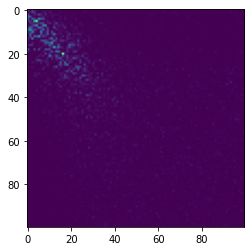

In [64]:
# Gram matrix of input 
_,_,Vi = torch.svd(weights1[0])
_,_,Vj = torch.svd(weights2[0])
Vi,Vj = Vi.to('cpu'),Vj.to('cpu')
gram = Vi.T@Vj
plt.imshow((gram**2))
plt.show()